In [3]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageEnhance

from universal.data_loading import download_training_data, get_trainval_dataset, \
     VOCDataset, test_transforms, train_transforms, classes, universal_transforms, normalize
from universal.deepfool import deepfool
from universal.plot import plot_images, normalize_image
from universal.universal_pert import universal_perturbation
from universal.vgg11_model import *
import logging
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader, Subset
import argparse
import torchvision.models as models
import random

In [4]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
OUTPUT_DIM = 20
device = 'cpu'
model = VGG(vgg11_layers, OUTPUT_DIM, device)

In [5]:
train_data_df, valid_data_df = get_trainval_dataset('.data/VOC2012')
# test_data_df = get_test_dataset(args.test_data)

train_data = VOCDataset(train_data_df, '.data/VOC2012', train_transforms)
valid_data = VOCDataset(valid_data_df, '.data/VOC2012', test_transforms)

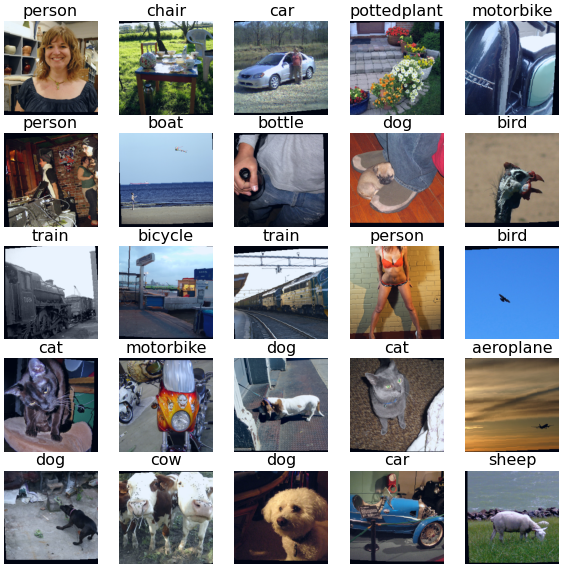

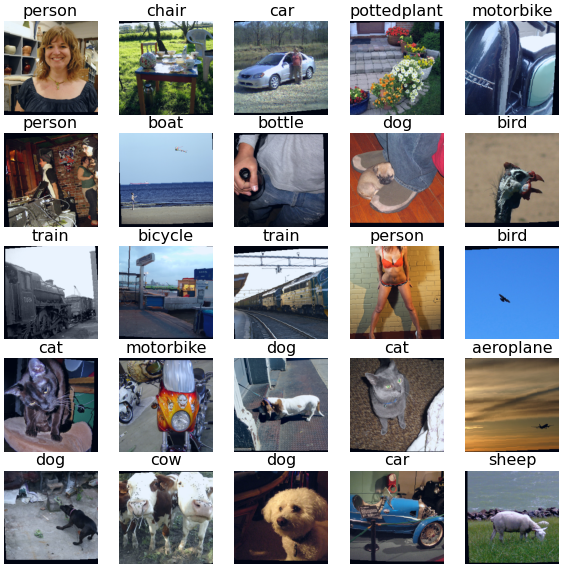

In [7]:
images, labels = zip(*[(image, label) for image, label in
                               [train_data[i] for i in random.sample(range(len(train_data)), 25)]])

plot_images(images, labels, classes)

In [8]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('vg11-voc2012-model.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
def classifier(img):
    if img.ndim == 3:
        img = img.unsqueeze(0)
    img = normalize(img)
    v = model(img)[0]
    return v

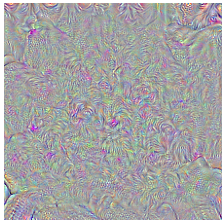

In [11]:
def change_contrast(img, factor):
    return np.clip(128 + factor * img - factor * 128, 0, 255).astype(np.uint8)

v = np.load('precomputed/VGG-11.npy')
a = v.squeeze().transpose(1, 2, 0)

#logging.info(f"Perturbation vector norm = {np.linalg.norm(abs(a))}")
#a = np.abs(a)
perturbation = (((a - np.min(a))/np.ptp(a)) * 255).astype(np.uint8)
#plt.figure(figsize=(7, 7))
plt.imshow(change_contrast(perturbation, 2.))
plt.axis('off')
plt.savefig('computed_perturbation.pdf')  

In [12]:
valid_data.transform = universal_transforms

/tmp/ipykernel_39187/4152296524.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  fig = plot_images(np.array(images)[well_classified], predicted[well_classified], classes, true_labels=np.array(labels)[well_classified])
/tmp/ipykernel_39187/4152296524.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plot_images(np.array(images)[well_classified], predicted[

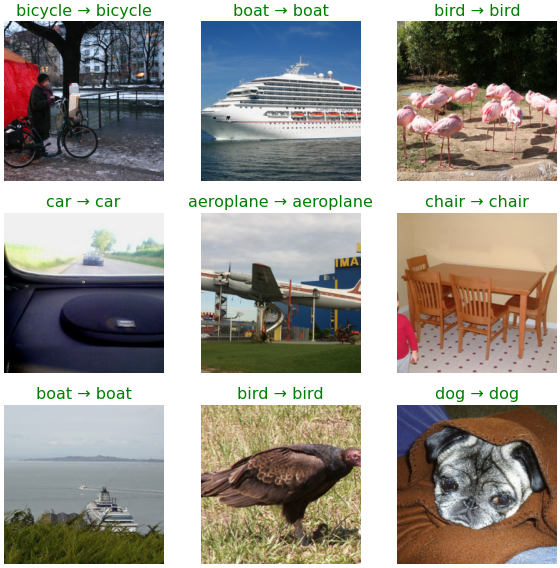

In [13]:
torch.cuda.empty_cache()
sample = random.sample(range(len(valid_data)), 13)
images, labels = zip(*[(image, label) for image, label in
                                   [valid_data[i] for i in sample]])
outputs = classifier(torch.stack(images).to(device))
predicted = outputs.argmax(dim=1)
well_classified = np.where(np.array(labels) == predicted.numpy())
fig = plot_images(np.array(images)[well_classified], predicted[well_classified], classes, true_labels=np.array(labels)[well_classified])

/tmp/ipykernel_39187/3019990127.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plot_images(np.array(images)[well_classified], predicted_perturbed[well_classified], classes, true_labels=np.array(predicted)[well_classified])
/tmp/ipykernel_39187/3019990127.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_images(np.array(images)[well_classified], predicted

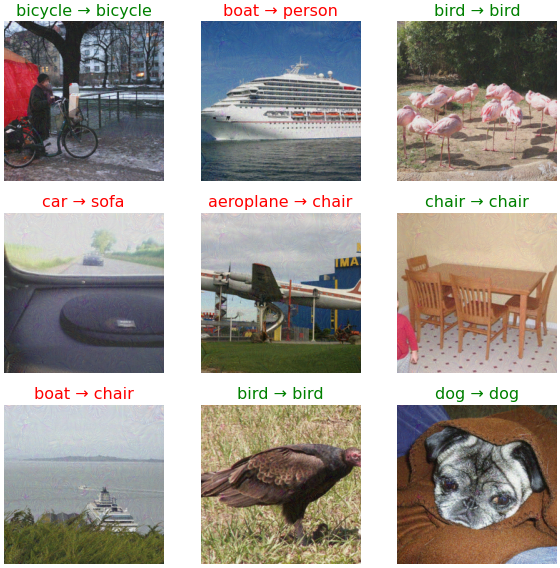

In [14]:
images, labels = zip(*[(image + v.squeeze(), label) for image, label in
                                   [valid_data[i] for i in sample]])

outputs = classifier(torch.stack(images).to(device))
predicted_perturbed = outputs.argmax(dim=1)

plot_images(np.array(images)[well_classified], predicted_perturbed[well_classified], classes, true_labels=np.array(predicted)[well_classified])
plt.savefig('perturbed_image.pdf')  

In [15]:
count = 5
norms = [0, 2000, 4000, 6000, 8000]
i = 3

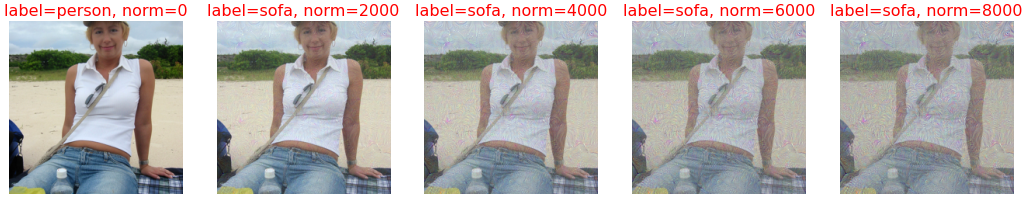

In [16]:
from universal.plot import normalize_image
img, label = valid_data[sample[i]]
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = v * (norm / np.linalg.norm(v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()
plt.savefig('evolution0.pdf') 

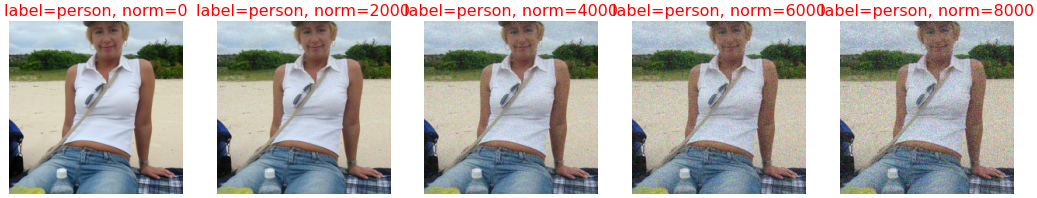

In [17]:
random_v =  np.random.uniform(low=v.min(), high=v.max(), size=(1, 3, 224, 224)).astype(np.float32)
imgs_perturbed = []
for norm in norms:
    norm = norm / 255
    normalized_v = random_v * (norm / np.linalg.norm(random_v))
    imgs_perturbed.append(img + normalized_v.squeeze())
    
outputs = classifier(torch.stack(imgs_perturbed).to(device))
predicted_perturbed = outputs.argmax(dim=1)
fig, axs = plt.subplots(1, count, figsize=(18, 10))
for i, ax in enumerate(axs):
    ax.imshow(normalize_image(imgs_perturbed[i]).numpy().transpose(1, 2, 0))
    ax.set_title(f"label={classes[predicted_perturbed[i]]}, norm={int(norms[i])}", color= "green" if predicted_perturbed[i] == label else "red")
    ax.set_axis_off()
    
plt.savefig('evolution1.pdf')  

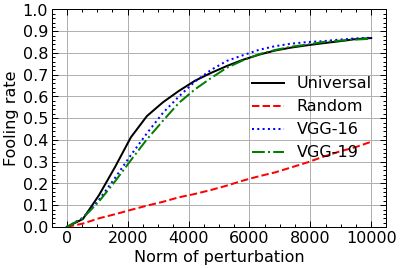

In [18]:
universal, random, bias, vgg16, vgg19 = np.load("exp1.npy")
norms = np.linspace(0., 10000, 20)
fig, ax = plt.subplots()
ax.plot(norms, universal, label="Universal")
ax.plot(norms, random, label="Random")
#ax.plot(norms, bias, label="Bias")
ax.plot(norms, vgg16, label="VGG-16")
ax.plot(norms, vgg19, label="VGG-19")
ax.set_xlabel("Norm of perturbation")
ax.set_ylabel("Fooling rate")
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
plt.grid()
ax.legend()
plt.savefig('curves.pdf')  

In [20]:
adj = np.zeros((len(classes), len(classes))).astype(int)
for i, j in np.load('exp2.npy').squeeze(0).astype(int):
    if i != j:
        adj[i, j] = adj[i, j] + 1

In [21]:
import pandas as pd

df = pd.DataFrame(adj)
renaming = {i: name for i, name in enumerate(classes)}
df.rename(columns=renaming,index=renaming, inplace=True)
df

,bicycle,horse,cat,dog,pottedplant,aeroplane,sofa,bus,car,chair,bird,boat,cow,bottle,diningtable,person,tvmonitor,sheep,motorbike,train
bicycle,0,1,1,8,5,0,4,0,2,24,3,0,0,0,0,42,0,0,2,0
horse,0,0,7,75,1,0,1,0,0,8,0,0,1,0,0,8,0,0,0,0
cat,0,0,0,63,0,0,15,0,0,1,0,0,0,0,0,2,0,0,0,0
dog,0,0,27,0,1,0,8,0,0,2,3,0,0,0,0,5,0,1,0,1
pottedplant,0,0,1,2,0,0,27,0,1,40,1,0,0,0,0,8,0,0,0,0
aeroplane,1,0,4,10,3,0,64,0,2,140,2,1,0,0,0,62,0,0,0,1
sofa,0,0,2,3,2,0,0,0,0,8,0,0,0,0,0,4,0,0,0,0
bus,0,0,0,0,2,0,10,0,13,3,0,0,0,0,0,34,1,0,0,4
car,0,0,5,7,21,0,44,1,0,23,0,0,0,0,0,56,0,0,5,1
chair,0,0,5,3,14,0,76,0,0,0,2,0,0,3,0,30,0,0,0,0


<AxesSubplot:>

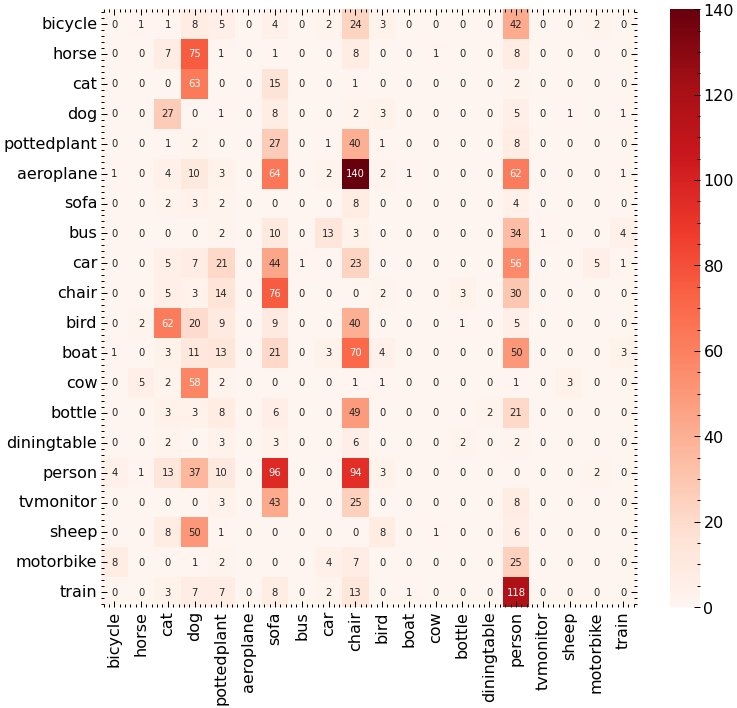

In [22]:
import seaborn as sns
plt.figure(figsize = (12,11))
sns.heatmap(df, annot=True,cmap='Reds', fmt='g')


In [117]:
df.to_csv("graph_data.csv")